<a href="https://colab.research.google.com/github/lorenz0leoncin1/bigdataproject/blob/main/Collaborative_Filtering_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [1]:
# Import necessary libraries for data manipulation, visualization, and similarity calculations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import zipfile
from sklearn.preprocessing import MinMaxScaler


# Step 2: Environment Setup and Data Download

In [2]:
# Set environment variables for Kaggle API (remove before submitting)
os.environ['KAGGLE_USERNAME'] = "PUT YOURS"
os.environ['KAGGLE_KEY'] = "PUT YOURS"

# Download the dataset using Kaggle API
!kaggle datasets download -d gsimonx37/letterboxd

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
100% 22.5G/22.5G [02:55<00:00, 146MB/s]
100% 22.5G/22.5G [02:55<00:00, 137MB/s]


# Step 3: Extract Dataset


In [303]:
# Percorsi e file specifici
zip_file_path = 'letterboxd.zip'
extract_path = 'data/'
files_to_extract = ['actors.csv', 'genres.csv', 'movies.csv']

def extract_specific_files(zip_path, extract_dir, files_list):
    # Assicurati che la directory di estrazione esista
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Ottieni la lista di tutti i file nel file ZIP
        all_files = zip_ref.namelist()

        # Filtra i file che desideri estrarre
        files_to_extract = [file for file in all_files if file in files_list]

        # Estrai solo i file specificati
        for file in files_to_extract:
            zip_ref.extract(file, extract_dir)
            print(f"Extracted: {file}")

# Chiama la funzione per estrarre i file specifici
extract_specific_files(zip_file_path, extract_path, files_to_extract)

Extracted: actors.csv
Extracted: genres.csv
Extracted: movies.csv


# Step 4: Load the datasets into the Dataframes

In [304]:
# Define a function to load, process, and subsample CSV files in chunks
def load_and_process_csv(file_path, chunk_size=40000, subsampling_enabled=False, subsampling_size=0.01):
    chunks = []

    # Read and process the file in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunks.append(chunk)  # Collect chunks if needed

    # Combine chunks into a single DataFrame if necessary, check and drop duplicates
    combined_df = pd.concat(chunks, ignore_index=True)
    combined_df = combined_df.drop_duplicates()
    print(f"Shape of the DataFrame before subsampling for {file_path}: {combined_df.shape}")

    # Apply subsampling if enabled
    if subsampling_enabled:
        combined_df = combined_df.sample(frac=subsampling_size, random_state=42)
        print(f"Shape of the DataFrame after subsampling for {file_path}: {combined_df.shape}")

    return combined_df

# Global variable to enable or disable subsampling
RANDOM_SUBSAMPLING = True  # Set True to enable subsampling, False to disable it
SUBSAMPLING_SIZE = 0.1   # Subsampling size (percentage of the dataset)

# Load and process each CSV file with optional subsampling
df_actors = load_and_process_csv('data/actors.csv', subsampling_enabled=RANDOM_SUBSAMPLING, subsampling_size=SUBSAMPLING_SIZE)
df_genres = load_and_process_csv('data/genres.csv', subsampling_enabled=RANDOM_SUBSAMPLING, subsampling_size=SUBSAMPLING_SIZE)
df_movies = load_and_process_csv('data/movies.csv', subsampling_enabled=RANDOM_SUBSAMPLING, subsampling_size=SUBSAMPLING_SIZE)


Shape of the DataFrame before subsampling for data/actors.csv: (5797504, 3)
Shape of the DataFrame after subsampling for data/actors.csv: (579750, 3)
Shape of the DataFrame before subsampling for data/genres.csv: (1046849, 2)
Shape of the DataFrame after subsampling for data/genres.csv: (104685, 2)
Shape of the DataFrame before subsampling for data/movies.csv: (941597, 7)
Shape of the DataFrame after subsampling for data/movies.csv: (94160, 7)


In [305]:
print(df_actors.info())
print(df_actors.head())

print(df_genres.info())
print(df_genres.head())

print(df_movies.info())
print(df_movies.head())


<class 'pandas.core.frame.DataFrame'>
Index: 579750 entries, 524783 to 690988
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      579750 non-null  int64 
 1   name    579750 non-null  object
 2   role    443759 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.7+ MB
None
              id                 name               role
524783   1017751         Robert Morse  J. Pierpont Finch
4631798  1545017      Daniel Bermudez     Johnny Thunder
890051   1038132  Shinnosuke Kasahara              Yoshi
270922   1007073         Gregg Daniel  English Professor
2424699  1176293      Kanako Miyamoto        Kō Sawatari
<class 'pandas.core.frame.DataFrame'>
Index: 104685 entries, 201116 to 876958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      104685 non-null  int64 
 1   genre   104685 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB

In [306]:
print(df_actors.dtypes)
print(df_genres.dtypes)
print(df_movies.dtypes)


id       int64
name    object
role    object
dtype: object
id        int64
genre    object
dtype: object
id               int64
name            object
date           float64
tagline         object
description     object
minute         float64
rating         float64
dtype: object


In [307]:
print(df_actors.duplicated().sum())
print(df_actors.isnull().sum())

print(df_genres.duplicated().sum())
print(df_genres.isnull().sum())

print(df_movies.duplicated().sum())
print(df_movies.isnull().sum())


0
id           0
name         0
role    135991
dtype: int64
0
id       0
genre    0
dtype: int64
0
id                 0
name               3
date            9068
tagline        80222
description    16127
minute         18144
rating         84939
dtype: int64


#Step 5: Pre-Processing of 'movies' dataset

In [308]:
df_movies.head()

,id,name,date,tagline,description,minute,rating
920492,1920493,Nesalauztie,2001.0,NaN,NaN,25.0,NaN
861368,1861369,U2 Live at Los Angeles 2018,2018.0,NaN,NaN,NaN,NaN
847808,1847809,ONDAR Florent Peyre,NaN,NaN,NaN,NaN,NaN
521859,1521860,Seed Corn Should Not Be Ground – A Portrait of...,1967.0,NaN,Tetzlaff's documentary combines historic film ...,20.0,NaN
204483,1204484,Computer Movie No.2,1969.0,NaN,Computer Movie No. 2 is a CGI animation create...,8.0,NaN


In [309]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94160 entries, 920492 to 918889
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           94160 non-null  int64  
 1   name         94157 non-null  object 
 2   date         85092 non-null  float64
 3   tagline      13938 non-null  object 
 4   description  78033 non-null  object 
 5   minute       76016 non-null  float64
 6   rating       9221 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 5.7+ MB


In [310]:
# Convert 'date' column to datetime format
df_movies['date'] = pd.to_datetime(df_movies['date'], errors='coerce', format='%Y')

# Extract the year and ensure it is in integer format
df_movies['date'] = df_movies['date'].dt.year.astype('Int64')  # or 'int64' if you don't expect NaN values


In [311]:
from sklearn.preprocessing import MinMaxScaler

# Creazione dello scaler
scaler = MinMaxScaler()

# Adatta e trasforma solo la colonna 'minute'
df_movies[['minute']] = scaler.fit_transform(df_movies[['minute']])


In [312]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94160 entries, 920492 to 918889
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           94160 non-null  int64  
 1   name         94157 non-null  object 
 2   date         85092 non-null  Int64  
 3   tagline      13938 non-null  object 
 4   description  78033 non-null  object 
 5   minute       76016 non-null  float64
 6   rating       9221 non-null   float64
dtypes: Int64(1), float64(2), int64(1), object(3)
memory usage: 5.8+ MB


### Missing Data Analysis

After examining the `movies` dataset, we observed the following percentages of missing values in key columns:

- **`date`:** 9.76% missing
- **`tagline`:** 85.20% missing
- **`description`:** 17.08% missing
- **`minute`:** 19.28% missing
- **`rating`:** 90.34% missing

#### Analysis of Missing Data

1. **High Percentage of Missing Values:**
   - **`tagline` (85.20%)** and **`rating` (90.34%)** have extremely high percentages of missing data. This indicates that these fields are not reliably available or were inconsistently recorded in the dataset. Retaining these columns could introduce significant bias or reduce the robustness of any analysis that includes them.

2. **Moderate Percentage of Missing Values:**
   - **`date` (9.76%)**, **`description` (17.08%)**, and **`minute` (19.28%)** have moderate levels of missing data. While these columns have more complete data than `tagline` and `rating`, the missing values still need to be handled appropriately to ensure accurate analysis results.

#### Decision on Handling Missing Data

Given the high percentages of missing values in the `tagline` and `rating` columns, we have decided to **drop these columns** from the dataset. The rationale behind this decision is as follows:

- **`tagline`:** With over 85% of the values missing, the tagline column lacks sufficient data to contribute meaningfully to any analysis. Including this column could potentially skew results and reduce analytical clarity.

- **`rating`:** With more than 90% of the values missing, the rating column does not provide a reliable measure for movie ratings. Given the lack of data, retaining this column would not be useful for our analysis.

We are also going to drop the column `description` just because we are not gonna use it.

By dropping these columns, we aim to streamline our dataset and focus on more complete data, ensuring a more robust and reliable analysis. For the remaining columns (`date` and `minute`), we will consider appropriate imputation or data cleaning strategies to handle the missing values effectively.


In [313]:
# Let's find the missing values of the columns: date, tagline,description,minute, rating

# Calculate the percentage of missing values for each specified column
missing_values = df_movies[['date', 'tagline', 'description', 'minute', 'rating']].isnull().sum()
missing_percentage = (missing_values / len(df_movies)) * 100

# Display the results
print("Missing Values Percentage:")
print(missing_percentage)


Missing Values Percentage:
date            9.630416
tagline        85.197536
description    17.127230
minute         19.269329
rating         90.207094
dtype: float64


In [314]:
# Drop 'tagline' and 'rating' columns due to high percentage of missing values
df_movies.drop(columns=['tagline', 'rating','description'], inplace=True)

# Display the updated DataFrame
print(df_movies.info())


<class 'pandas.core.frame.DataFrame'>
Index: 94160 entries, 920492 to 918889
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      94160 non-null  int64  
 1   name    94157 non-null  object 
 2   date    85092 non-null  Int64  
 3   minute  76016 non-null  float64
dtypes: Int64(1), float64(1), int64(1), object(1)
memory usage: 3.7+ MB
None


### Analysis of remaining columns

In [315]:
# Drop rows where 'name' is missing
df_movies = df_movies.dropna(subset=['name'])


In [316]:
# Drop rows where 'date' is missing
df_movies = df_movies.dropna(subset=['date'])

In [317]:
# Drop rows where 'minute' is missing
df_movies = df_movies.dropna(subset=['minute'])

In [318]:
# Display updated DataFrame information
print(df_movies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 71225 entries, 920492 to 918889
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      71225 non-null  int64  
 1   name    71225 non-null  object 
 2   date    71225 non-null  Int64  
 3   minute  71225 non-null  float64
dtypes: Int64(1), float64(1), int64(1), object(1)
memory usage: 2.8+ MB
None


In [319]:
# Verifica dati mancanti nel DataFrame finale
missing_values_final = df_movies.isnull().sum()
print("Missing Values Percentage After Final Processing:")
print((missing_values_final / len(df_movies)) * 100)

# Controllo dei duplicati
duplicates = df_movies.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Esplora il dataset
print(df_movies.head())

# Salva il DataFrame pulito
df_movies.to_csv('data/cleaned_movies.csv', index=False)


Missing Values Percentage After Final Processing:
id        0.0
name      0.0
date      0.0
minute    0.0
dtype: float64
Number of duplicate rows: 0
             id                                               name  date  \
920492  1920493                                        Nesalauztie  2001   
521859  1521860  Seed Corn Should Not Be Ground – A Portrait of...  1967   
204483  1204484                                Computer Movie No.2  1969   
574741  1574742                                     Boss With Love  2023   
668553  1668554                             My Sister-in-law's Job  2017   

          minute  
920492  0.001802  
521859  0.001427  
204483  0.000526  
574741  0.006307  
668553  0.006608  


# Step 6: Pre-Processing of 'actors' dataset

In [320]:
# Overview of the actors DataFrame
print(df_actors.info())
print(df_actors.head())

<class 'pandas.core.frame.DataFrame'>
Index: 579750 entries, 524783 to 690988
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      579750 non-null  int64 
 1   name    579750 non-null  object
 2   role    443759 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.7+ MB
None
              id                 name               role
524783   1017751         Robert Morse  J. Pierpont Finch
4631798  1545017      Daniel Bermudez     Johnny Thunder
890051   1038132  Shinnosuke Kasahara              Yoshi
270922   1007073         Gregg Daniel  English Professor
2424699  1176293      Kanako Miyamoto        Kō Sawatari


In [321]:
# Check for missing values in the actors DataFrame
missing_values_actors = df_actors.isnull().sum()
missing_percentage_actors = (missing_values_actors / len(df_actors)) * 100

print("Missing Values Percentage in Actors Table:")
print(missing_percentage_actors)

Missing Values Percentage in Actors Table:
id       0.000000
name     0.000000
role    23.456835
dtype: float64


In [322]:
# Remove rows where 'name' is missing
df_actors.dropna(subset=['name'], inplace=True)

In [323]:
# Fill missing 'role' values with 'unknown'
df_actors['role'].fillna('unknown', inplace=True)

In [324]:
# Convert all names and roles to lowercase for consistency
df_actors['name'] = df_actors['name'].str.lower()
df_actors['role'] = df_actors['role'].str.lower()

In [325]:
# Optimize the id column if needed (convert to int32 if applicable)
df_actors['id'] = df_actors['id'].astype('int32')

In [326]:
print(df_actors.info())

<class 'pandas.core.frame.DataFrame'>
Index: 579750 entries, 524783 to 690988
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      579750 non-null  int32 
 1   name    579750 non-null  object
 2   role    579750 non-null  object
dtypes: int32(1), object(2)
memory usage: 15.5+ MB
None


In [327]:
df_actors.head()

,id,name,role
524783,1017751,robert morse,j. pierpont finch
4631798,1545017,daniel bermudez,johnny thunder
890051,1038132,shinnosuke kasahara,yoshi
270922,1007073,gregg daniel,english professor
2424699,1176293,kanako miyamoto,kō sawatari


In [328]:
# Conta il numero di attori unici
num_unique_actors = df_actors['name'].nunique()
print(f"Numero di attori unici: {num_unique_actors}")


Numero di attori unici: 333946


In [329]:
# Ottieni una lista degli attori unici
unique_actors = df_actors['name'].unique()
print(f"Numero di attori unici: {len(unique_actors)}")
print("Prime 10 attori unici:")
print(unique_actors[:10])  # Mostra i primi 10 attori unici


Numero di attori unici: 333946
Prime 10 attori unici:
['robert morse' 'daniel bermudez' 'shinnosuke kasahara' 'gregg daniel'
 'kanako miyamoto' 'rosie alvarez' 'lettie shumate' 'samuel joslin'
 'rajaa mounssif' 'v. larin']


In [330]:
# Verifica se ci sono attori con nomi duplicati
duplicate_actors = df_actors[df_actors.duplicated(subset=['name'], keep=False)]
print(f"Numero di righe con attori duplicati: {duplicate_actors.shape[0]}")


Numero di righe con attori duplicati: 335080


In [331]:
# Conta il numero di partecipazioni per attore
actor_participations = df_actors['name'].value_counts()
print(actor_participations.head(10))  # Mostra i primi 10 attori con più partecipazioni


name
mel blanc            117
bess flowers          84
jagathy sreekumar     61
brahmanandam          55
sukumari              54
manorama              54
mammootty             51
gulshan grover        43
eric roberts          42
mohanlal              41
Name: count, dtype: int64


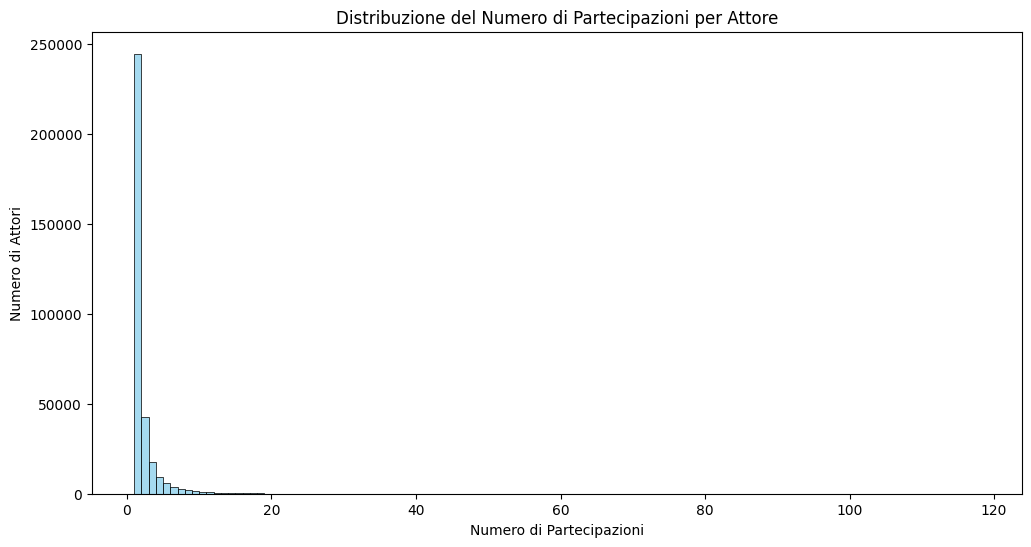

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conta il numero di partecipazioni per attore
actor_participations = df_actors['name'].value_counts()

# Configura il grafico
plt.figure(figsize=(12, 6))
sns.histplot(actor_participations, bins=range(1, actor_participations.max() + 2), kde=False, color='skyblue')
plt.title('Distribuzione del Numero di Partecipazioni per Attore')
plt.xlabel('Numero di Partecipazioni')
plt.ylabel('Numero di Attori')
plt.show()


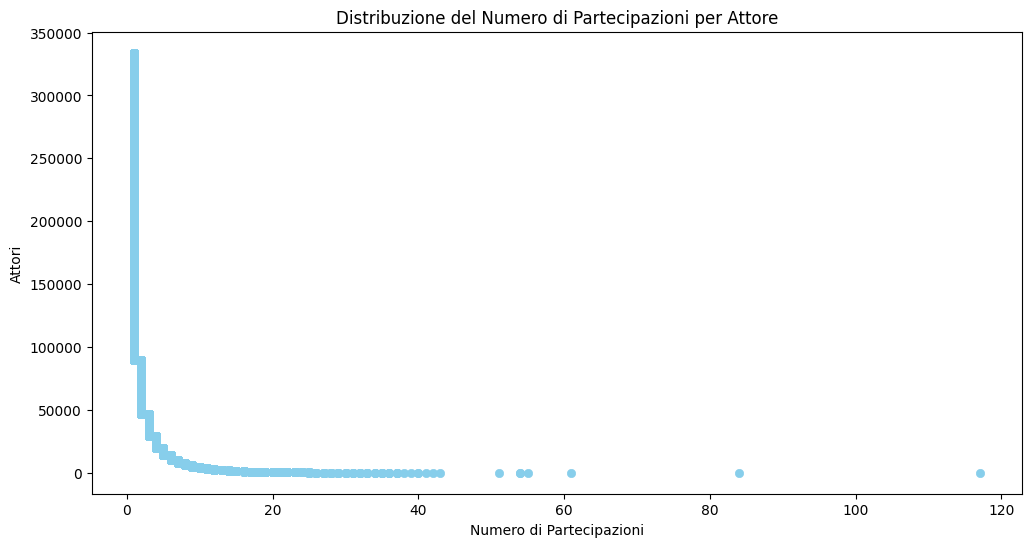

In [333]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conta il numero di partecipazioni per attore
actor_participations = df_actors['name'].value_counts().reset_index()
actor_participations.columns = ['actor', 'participations']

# Configura il grafico
plt.figure(figsize=(12, 6))
sns.scatterplot(x='participations', y=actor_participations.index, data=actor_participations, color='skyblue', edgecolor=None)
plt.title('Distribuzione del Numero di Partecipazioni per Attore')
plt.xlabel('Numero di Partecipazioni')
plt.ylabel('Attori')
plt.show()


#Step 7: Pre-Processing of 'genre' dataset

In [334]:
print(df_genres.info())
print(df_genres.head())

<class 'pandas.core.frame.DataFrame'>
Index: 104685 entries, 201116 to 876958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      104685 non-null  int64 
 1   genre   104685 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None
             id            genre
201116  1102360           Horror
700610  1499528  Science Fiction
992349  1843017            Drama
141147  1067955            Drama
862078  1676465      Documentary


In [335]:
missing_values = df_genres.isnull().sum()
missing_percentage = (missing_values / len(df_genres)) * 100

print("Missing Values Percentage in Genres Table:")
print(missing_percentage)


Missing Values Percentage in Genres Table:
id       0.0
genre    0.0
dtype: float64


In [336]:
# prompt: find duplicates in genres

duplicate_rows = df_genres[df_genres.duplicated()]
print("Duplicated Rows:")
print(duplicate_rows)


Duplicated Rows:
Empty DataFrame
Columns: [id, genre]
Index: []


In [337]:
df_genres['genre'] = df_genres['genre'].str.lower()

In [338]:
# Convert id to a more memory-efficient type if applicable
df_genres['id'] = df_genres['id'].astype('int32')

In [339]:
print(df_genres.info())

<class 'pandas.core.frame.DataFrame'>
Index: 104685 entries, 201116 to 876958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      104685 non-null  int32 
 1   genre   104685 non-null  object
dtypes: int32(1), object(1)
memory usage: 2.0+ MB
None


In [340]:
df_genres.head()

,id,genre
201116,1102360,horror
700610,1499528,science fiction
992349,1843017,drama
141147,1067955,drama
862078,1676465,documentary


##Group by Movie ID and Aggregate Genres
   - Group the `genres` DataFrame by the `id` column (which represents the movie ID).
   - Concatenate all `genre` values for each movie into a single string, with genres separated by commas.


In [341]:
# Group by 'id' and aggregate genres into a single string separated by commas
df_genres = df_genres.groupby('id')['genre'].apply(lambda x: ', '.join(x)).reset_index()

# Rename the aggregated genre column for clarity
df_genres.rename(columns={'genre': 'genres'}, inplace=True)
print(df_genres.head())

        id     genres
0  1000001     comedy
1  1000005      music
2  1000006      drama
3  1000007  adventure
4  1000012      music


In [342]:
print(df_genres.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99650 entries, 0 to 99649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      99650 non-null  int32 
 1   genres  99650 non-null  object
dtypes: int32(1), object(1)
memory usage: 1.1+ MB
None


# Step 8: Making considerations about dfs

In [343]:
# Informations about the three tables, df_movies, df_actors and df_genres

# Display information about df_movies
print("df_movies Information:")
print(df_movies.info())
print(df_movies.head())
print("\n")

# Display information about df_actors
print("df_actors Information:")
print(df_actors.info())
print(df_actors.head())
print("\n")

# Display information about df_genres_aggregated (since it's the processed genres table)
print("df_genres Information:")
print(df_genres.info())
print(df_genres.head())


df_movies Information:
<class 'pandas.core.frame.DataFrame'>
Index: 71225 entries, 920492 to 918889
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      71225 non-null  int64  
 1   name    71225 non-null  object 
 2   date    71225 non-null  Int64  
 3   minute  71225 non-null  float64
dtypes: Int64(1), float64(1), int64(1), object(1)
memory usage: 2.8+ MB
None
             id                                               name  date  \
920492  1920493                                        Nesalauztie  2001   
521859  1521860  Seed Corn Should Not Be Ground – A Portrait of...  1967   
204483  1204484                                Computer Movie No.2  1969   
574741  1574742                                     Boss With Love  2023   
668553  1668554                             My Sister-in-law's Job  2017   

          minute  
920492  0.001802  
521859  0.001427  
204483  0.000526  
574741  0.006307  
668553  0.006608 

# Step 9: Merging movies and their genres

In [344]:
# Merge df_movies with df_genres to include genres in the utility matrix
df_movies_with_genres = pd.merge(df_movies, df_genres, on='id', how='inner')

df_movies_with_genres.head()


,id,name,date,minute,genres
0,1668554,My Sister-in-law's Job,2017,0.006608,drama
1,1382627,Bazaar,2019,0.010963,action
2,1348395,Klann - grand guignol,1970,0.006683,mystery
3,1257912,A Hollywood Hounds Christmas,1994,0.001577,music
4,1037588,Love Camp 7,1969,0.007133,horror


One-Hot Encoding on genres cause is a categorical feature and then our df for moies is ready


In [345]:
# One Hot Encoding
df_movies_with_genres = df_movies_with_genres.join(df_movies_with_genres['genres'].str.get_dummies(', '))
# Removing one-hot encoded column
df_movies_with_genres = df_movies_with_genres.drop(columns=['genres'])
df_movies_with_genres.head()

,id,name,date,minute,action,adventure,animation,comedy,crime,documentary,...,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,1668554,My Sister-in-law's Job,2017,0.006608,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1382627,Bazaar,2019,0.010963,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1348395,Klann - grand guignol,1970,0.006683,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1257912,A Hollywood Hounds Christmas,1994,0.001577,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1037588,Love Camp 7,1969,0.007133,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [346]:
# Merge the resulting table with df_actors to have actors, movies, and genres together
df_actor_movie_genre = pd.merge(df_actors, df_movies_with_genres, on='id', how='inner')
df_actor_movie_genre.head()

,id,name_x,role,name_y,date,minute,action,adventure,animation,comedy,...,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,1128225,ray ventura,mateo brother #1,Kiss the Sky,1998,0.007809,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1128225,angelena bonet,fantasy girl #1,Kiss the Sky,1998,0.007809,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1318716,liu hua,unknown,Bright Future,2009,0.006683,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1318716,li yu,unknown,Bright Future,2009,0.006683,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1028473,ila arun,vidya's mother-in-law,Sherni,2021,0.009686,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [347]:
# Print column names to check if 'name' exists
print(df_actor_movie_genre.columns)


Index(['id', 'name_x', 'role', 'name_y', 'date', 'minute', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science fiction', 'thriller', 'tv movie', 'war', 'western'],
      dtype='object')


In [348]:
# Rename columns for clarity
df_actor_movie_genre.rename(columns={'name_x': 'actor_name', 'name_y': 'movie_name'}, inplace=True)

#Analisi del problema tra genre e movies

In [349]:
df_actor_movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8582 non-null   int32  
 1   actor_name       8582 non-null   object 
 2   role             8582 non-null   object 
 3   movie_name       8582 non-null   object 
 4   date             8582 non-null   Int64  
 5   minute           8582 non-null   float64
 6   action           8582 non-null   int64  
 7   adventure        8582 non-null   int64  
 8   animation        8582 non-null   int64  
 9   comedy           8582 non-null   int64  
 10  crime            8582 non-null   int64  
 11  documentary      8582 non-null   int64  
 12  drama            8582 non-null   int64  
 13  family           8582 non-null   int64  
 14  fantasy          8582 non-null   int64  
 15  history          8582 non-null   int64  
 16  horror           8582 non-null   int64  
 17  music         

In [350]:
print(df_actor_movie_genre.shape)


(8582, 25)


In [351]:
print("Dimensioni di df_actors prima del merge:", df_actors.shape)
print("Dimensioni di df_movies_with_genres prima del merge:", df_movies_with_genres.shape)
print("Dimensioni di df_actor_movie_genre dopo il merge:", df_actor_movie_genre.shape)


Dimensioni di df_actors prima del merge: (579750, 3)
Dimensioni di df_movies_with_genres prima del merge: (8524, 23)
Dimensioni di df_actor_movie_genre dopo il merge: (8582, 25)


In [352]:
print("ID unici in df_actors:", df_actors['id'].nunique())
print("ID unici in df_movies_with_genres:", df_movies_with_genres['id'].nunique())


ID unici in df_actors: 310429
ID unici in df_movies_with_genres: 8524


In [353]:
print(df_actors['id'].isnull().sum())
print(df_movies_with_genres['id'].isnull().sum())


0
0


In [354]:
print(df_actor_movie_genre.head())
print(df_actor_movie_genre.info())


        id      actor_name                   role     movie_name  date  \
0  1128225     ray ventura       mateo brother #1   Kiss the Sky  1998   
1  1128225  angelena bonet        fantasy girl #1   Kiss the Sky  1998   
2  1318716         liu hua                unknown  Bright Future  2009   
3  1318716           li yu                unknown  Bright Future  2009   
4  1028473        ila arun  vidya's mother-in-law         Sherni  2021   

     minute  action  adventure  animation  comedy  ...  history  horror  \
0  0.007809       0          0          0       0  ...        0       0   
1  0.007809       0          0          0       0  ...        0       0   
2  0.006683       0          0          0       1  ...        0       0   
3  0.006683       0          0          0       1  ...        0       0   
4  0.009686       0          0          0       0  ...        0       0   

   music  mystery  romance  science fiction  thriller  tv movie  war  western  
0      0        0       

In [355]:
print("Duplicati in df_actors:", df_actors.duplicated().sum())
print("Duplicati in df_movies_with_genres:", df_movies_with_genres.duplicated().sum())


Duplicati in df_actors: 0
Duplicati in df_movies_with_genres: 0


In [356]:
print("Distribuzione degli ID in df_actors:")
print(df_actors['id'].value_counts().describe())

print("Distribuzione degli ID in df_movies_with_genres:")
print(df_movies_with_genres['id'].value_counts().describe())


Distribuzione degli ID in df_actors:
count    310429.000000
mean          1.867577
std           1.460038
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          58.000000
Name: count, dtype: float64
Distribuzione degli ID in df_movies_with_genres:
count    8524.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64


In [357]:
missing_ids = df_actors[~df_actors['id'].isin(df_movies_with_genres['id'])]
print("Numero di ID in df_actors che non sono in df_movies_with_genres:", len(missing_ids))
print(missing_ids.head())


Numero di ID in df_actors che non sono in df_movies_with_genres: 571168
              id                 name               role
524783   1017751         robert morse  j. pierpont finch
4631798  1545017      daniel bermudez     johnny thunder
890051   1038132  shinnosuke kasahara              yoshi
270922   1007073         gregg daniel  english professor
2424699  1176293      kanako miyamoto        kō sawatari


In [358]:
movie_ids = df_movies_with_genres['id'].value_counts()
print("ID nei film con meno di 5 occorrenze:")
print(movie_ids[movie_ids < 5])


ID nei film con meno di 5 occorrenze:
id
1504488    1
1668554    1
1382627    1
1348395    1
1257912    1
          ..
1645594    1
1014113    1
1317606    1
1056380    1
1084571    1
Name: count, Length: 8524, dtype: int64


In [359]:
# Verifica la forma del DataFrame
print("Shape after merge:", df_movies_with_genres.shape)

# Controlla le prime righe del DataFrame
print(df_movies_with_genres.head())

# Controlla i valori unici degli ID nel DataFrame risultante
print("Unique IDs in df_movies_with_genres:", df_movies_with_genres['id'].nunique())

# Verifica se ci sono valori mancanti
print("Missing values in df_movies_with_genres:")
print(df_movies_with_genres.isnull().sum())

# Controlla i duplicati
print("Number of duplicate rows in df_movies_with_genres:", df_movies_with_genres.duplicated().sum())


Shape after merge: (8524, 23)
        id                          name  date    minute  action  adventure  \
0  1668554        My Sister-in-law's Job  2017  0.006608       0          0   
1  1382627                        Bazaar  2019  0.010963       1          0   
2  1348395         Klann - grand guignol  1970  0.006683       0          0   
3  1257912  A Hollywood Hounds Christmas  1994  0.001577       0          0   
4  1037588                   Love Camp 7  1969  0.007133       0          0   

   animation  comedy  crime  documentary  ...  history  horror  music  \
0          0       0      0            0  ...        0       0      0   
1          0       0      0            0  ...        0       0      0   
2          0       0      0            0  ...        0       0      0   
3          0       0      0            0  ...        0       0      1   
4          0       0      0            0  ...        0       1      0   

   mystery  romance  science fiction  thriller  tv movie

In [360]:
# Verifica gli ID unici in df_movies
unique_movie_ids = set(df_movies['id'])

# Verifica gli ID unici in df_genres
unique_genre_ids = set(df_genres['id'])

# Trova gli ID che sono presenti in df_movies ma non in df_genres
missing_genre_ids = unique_movie_ids - unique_genre_ids
print(f"Numero di ID in df_movies che non sono in df_genres: {len(missing_genre_ids)}")
print(f"ID mancanti: {list(missing_genre_ids)[:5]}")  # Mostra i primi 5 ID mancanti


Numero di ID in df_movies che non sono in df_genres: 62701
ID mancanti: [1441792, 1835010, 1179653, 1179656, 1441803]


In [361]:
# Conta le occorrenze degli ID in df_movies
movie_id_counts = df_movies['id'].value_counts()
print("ID nei film con più di una occorrenza:")
print(movie_id_counts[movie_id_counts > 1])

# Conta le occorrenze degli ID in df_genres
genre_id_counts = df_genres['id'].value_counts()
print("ID nei generi con più di una occorrenza:")
print(genre_id_counts[genre_id_counts > 1])


ID nei film con più di una occorrenza:
Series([], Name: count, dtype: int64)
ID nei generi con più di una occorrenza:
Series([], Name: count, dtype: int64)


In [362]:
# Esegui un join outer per vedere tutti i film e generi, anche se non hanno corrispondenza
df_movies_with_genres_outer = pd.merge(df_movies, df_genres, on='id', how='outer')

# Conta le righe
print(f"Dimensione dopo il merge outer: {df_movies_with_genres_outer.shape}")

# Verifica valori mancanti
print(df_movies_with_genres_outer.isna().sum())


Dimensione dopo il merge outer: (162351, 5)
id            0
name      91126
date      91126
minute    91126
genres    62701
dtype: int64


In [363]:
print(df_movies['id'].dtype)
print(df_genres['id'].dtype)
print(df_movies['id'].isna().sum())
print(df_genres['id'].isna().sum())


int64
int32
0
0


# Step 10: Creating Utility Matrix solo con movies e actors

In [379]:
df_actor_movie = pd.merge(df_actors, df_movies, left_on='id', right_on='id', how='inner')
df_actor_movie.head()

,id,name_x,role,name_y,date,minute
0,1020441,daniela blume,cliente 1,Father There Is Only One,2019,0.007058
1,1020441,jason tigreros,camarero,Father There Is Only One,2019,0.007058
2,1020441,alberto casado,psicólogo infantil,Father There Is Only One,2019,0.007058
3,1020441,marco ezcurdia,niño okupa,Father There Is Only One,2019,0.007058
4,1020441,pilar calvo morillas,programadora,Father There Is Only One,2019,0.007058


In [380]:
# Rename columns for clarity
df_actor_movie.rename(columns={'name_x': 'actor_name', 'name_y': 'movie_name'}, inplace=True)

In [381]:
utility_matrix = df_actor_movie.pivot_table(index='actor_name', columns='movie_name', values='minute', aggfunc='count', fill_value=0)


In [382]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcolo della matrice di similarità
similarity_array = cosine_similarity(utility_matrix)
similarity_matrix = pd.DataFrame(
    similarity_array,
    index=utility_matrix.index,
    columns=utility_matrix.index
)


Numero medio di attori per film: 1.98
Deviazione standard del numero di attori per film: 1.58


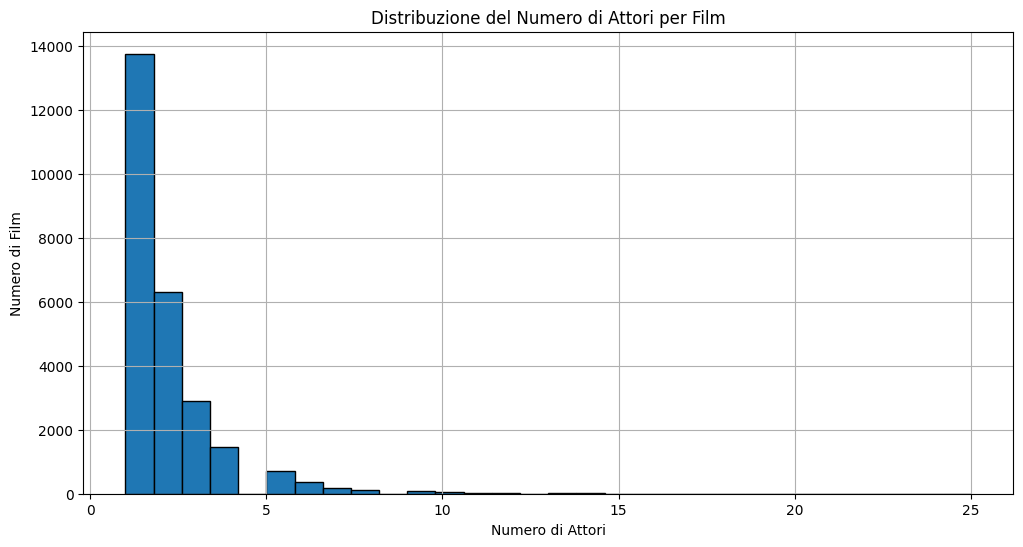

In [400]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponendo che df_actor_movie sia già caricato e contenga le colonne 'movie_name' e 'actor_name'

# Conta il numero di attori per ciascun film
movie_actor_counts = df_actor_movie.groupby('movie_name')['actor_name'].count()

# Calcola statistiche descrittive
mean_count = movie_actor_counts.mean()
std_count = movie_actor_counts.std()

# Stampa le statistiche
print(f"Numero medio di attori per film: {mean_count:.2f}")
print(f"Deviazione standard del numero di attori per film: {std_count:.2f}")

# Crea un istogramma per visualizzare la distribuzione
plt.figure(figsize=(12, 6))
plt.hist(movie_actor_counts, bins=30, edgecolor='black')
plt.title('Distribuzione del Numero di Attori per Film')
plt.xlabel('Numero di Attori')
plt.ylabel('Numero di Film')
plt.grid(True)
plt.show()


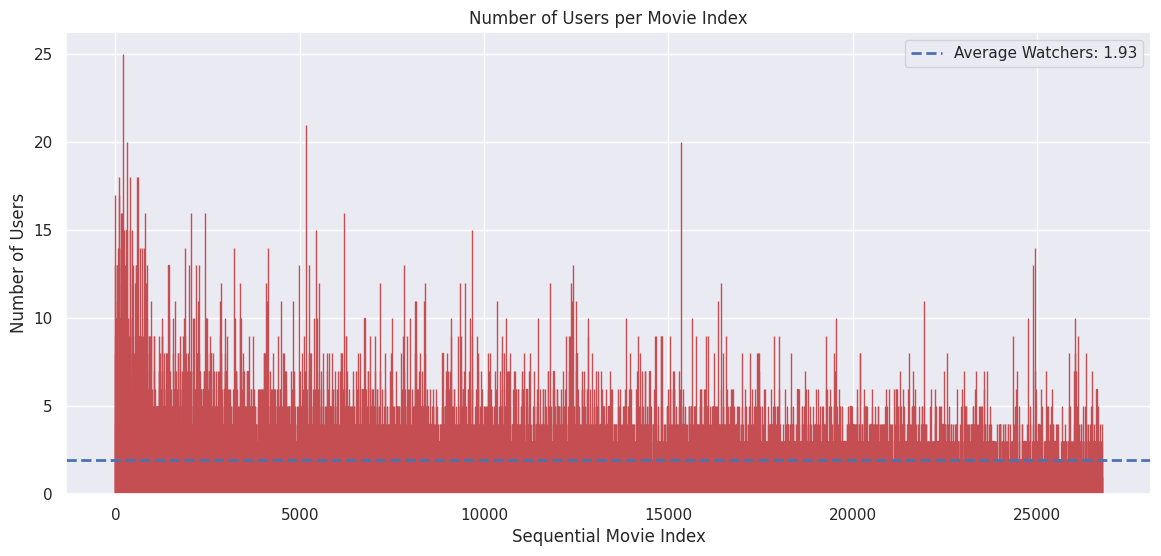

In [404]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supponendo che 'users' sia un DataFrame che contiene informazioni sugli utenti e i film
# Conta il numero di utenti per ciascun film
movie_user_counts = df_actor_movie.groupby('id')['actor_name'].count()

# Calcola la media del numero di utenti per film
average_watchers = movie_user_counts.mean()

# Imposta lo stile del grafico
sns.set(style="darkgrid")

# Crea la figura
plt.figure(figsize=(14, 6))

# Crea un grafico a barre
plt.bar(range(len(movie_user_counts)), movie_user_counts.values, edgecolor='r')

# Aggiunge una linea orizzontale per indicare la media
plt.axhline(average_watchers, color='b', linestyle='--', linewidth=2, label=f'Average Watchers: {average_watchers:.2f}')

# Aggiunge titolo e etichette agli assi
plt.title('Number of Users per Movie Index')
plt.xlabel('Sequential Movie Index')
plt.ylabel('Number of Users')

# Aggiunge una legenda
plt.legend()

# Mostra il grafico
plt.show()


In [393]:
def recommend_movies(actor_name, num_recommendations=5):
    # Verifica se l'attore è presente nella matrice di similarità
    if actor_name not in similarity_matrix.index:
        return "Attore non trovato nel campione."

    # Calcola la similarità
    similar_actors = similarity_matrix.loc[actor_name]
    print(f"Similar Actors: {similar_actors}")  # Debugging: Mostra gli attori simili

    # Trova gli indici degli attori più simili
    similar_indices = similar_actors.sort_values(ascending=False).index[1:num_recommendations+1]
    print(f"Similar Indices: {similar_indices}")  # Debugging: Mostra gli indici degli attori simili

    # Trova i film raccomandati
    recommendations = {}
    for movie in utility_matrix.columns:
        score = sum(
            utility_matrix.loc[similar_actor].get(movie, 0) * similar_actors[similar_actor]
            for similar_actor in similar_indices
            if similar_actor in utility_matrix.index
        )
        print(f"Movie: {movie}, Score: {score}")  # Debugging: Mostra il punteggio per ogni film
        if score > 0:  # Ignora film con punteggio zero
            recommendations[movie] = f"Totale punteggio basato sui film degli attori simili: {score:.2f}"

    print(f"Recommendations: {recommendations}")  # Debugging: Mostra le raccomandazioni

    if not recommendations:
        return "Nessuna raccomandazione disponibile basata sui punteggi."

    return dict(sorted(recommendations.items(), key=lambda item: item[1], reverse=True)[:num_recommendations])


In [394]:
import random

def recommend_for_random_actor(df_actors, recommend_movies, max_attempts=100):
    attempts = 0
    while attempts < max_attempts:
        random_actor = random.choice(df_actors['name'].tolist())
        recommendations = recommend_movies(random_actor)

        # Controlla se il risultato è una stringa di errore
        if isinstance(recommendations, str) and recommendations.startswith("Attore"):
            attempts += 1
        else:
            return random_actor, recommendations

    return None, "Nessun attore valido trovato dopo molti tentativi."

# Esegui la funzione per ottenere raccomandazioni
actor, recommendations = recommend_for_random_actor(df_actors, recommend_movies)

# Stampa le raccomandazioni
if actor:
    print(f"Attore scelto casualmente: {actor}")
    if isinstance(recommendations, dict):
        for movie, reason in recommendations.items():
            print(f"Film raccomandato: {movie}\nMotivo: {reason}\n")
    else:
        print(recommendations)  # Mostra il messaggio di errore se l'attore non è trovato
else:
    print(recommendations)  # Mostra il messaggio se non è stato trovato un attore valido


Streaming output truncated to the last 5000 lines.
Movie: The James Brothers of Missouri, Score: 0.0
Movie: The Jazz Detective, Score: 0.0
Movie: The Jekyll and Hyde Portfolio, Score: 0.0
Movie: The Jennie Project, Score: 0.0
Movie: The Jinkx and DeLa Holiday Show 2023, Score: 0.0
Movie: The Joe Spinell Story, Score: 0.0
Movie: The John Sullivan Story, Score: 0.0
Movie: The Joke, Score: 0.0
Movie: The Joker Is Wild, Score: 0.0
Movie: The Journey, Score: 0.0
Movie: The Journey Home, Score: 0.0
Movie: The Journey of Stars Into the Dark Night, Score: 0.0
Movie: The Journey to Kafiristan, Score: 0.0
Movie: The Joy of Life, Score: 0.0
Movie: The Joy of Living, Score: 0.0
Movie: The Joy of Music, Score: 0.0
Movie: The Judge, Score: 0.0
Movie: The Jump, Score: 0.0
Movie: The Junior Squad, Score: 0.0
Movie: The Jupiter Menace, Score: 0.0
Movie: The Jury's Secret, Score: 0.0
Movie: The Jönsson Gang & the Black Diamond, Score: 0.0
Movie: The Jönsson Gang's Greatest Robbery, Score: 0.0
Movie: The

In [399]:
# Seleziona la riga per l'attore specificato
actor_data = utility_matrix.loc['trevor peacock']

# Filtra i film con valori diversi da zero
non_zero_movies = actor_data[actor_data > 0]

# Stampa i film
print(non_zero_movies)

# Filtra il DataFrame per trovare le righe con il film specificato
actors_in_movie = df_actor_movie[df_actor_movie['movie_name'] == 'Henry VI Part 2']

# Trova gli attori che hanno partecipato a quel film
actors_list = actors_in_movie['actor_name'].tolist()

# Stampa gli attori
print(f"Attori che hanno partecipato al film 'Henry VI Part 2':")
print(actors_list)


movie_name
Henry VI Part 2    1
Name: trevor peacock, dtype: int64
Attori che hanno partecipato al film 'Henry VI Part 2':
['paul chapman', 'trevor peacock', 'peter benson']


# Creating Utility Matrix solo con movies e actors e genres che non funziona ad oggi

In [180]:
# Example size of df_actor_movie_genre
num_rows = df_actor_movie_genre.shape[0]
num_unique_actors = df_actor_movie_genre['actor_name'].nunique()
num_unique_movies = df_actor_movie_genre['movie_name'].nunique()

print(f"Number of rows in df_actor_movie_genre: {num_rows}")
print(f"Number of unique actors: {num_unique_actors}")
print(f"Number of unique movies: {num_unique_movies}")


Number of rows in df_actor_movie_genre: 8582
Number of unique actors: 8356
Number of unique movies: 4045


In [128]:
df_actor_movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8582 non-null   int32  
 1   actor_name       8582 non-null   object 
 2   role             8582 non-null   object 
 3   movie_name       8582 non-null   object 
 4   date             8582 non-null   Int64  
 5   minute           8582 non-null   float64
 6   action           8582 non-null   int64  
 7   adventure        8582 non-null   int64  
 8   animation        8582 non-null   int64  
 9   comedy           8582 non-null   int64  
 10  crime            8582 non-null   int64  
 11  documentary      8582 non-null   int64  
 12  drama            8582 non-null   int64  
 13  family           8582 non-null   int64  
 14  fantasy          8582 non-null   int64  
 15  history          8582 non-null   int64  
 16  horror           8582 non-null   int64  
 17  music         

In [129]:
from scipy.sparse import coo_matrix

# Factorize the 'actor_name' and 'movie_name' columns
actor_indices = pd.factorize(df_actor_movie_genre['actor_name'])[0]
movie_indices = pd.factorize(df_actor_movie_genre['movie_name'])[0]

# Create a sparse matrix using the factorized indices
sparse_matrix = coo_matrix((np.ones(len(df_actor_movie_genre)), (actor_indices, movie_indices)),
                           shape=(len(pd.unique(actor_indices)), len(pd.unique(movie_indices))))

print(f"Sparse matrix shape: {sparse_matrix.shape}")
print(f"Non-zero elements: {sparse_matrix.nnz}")


Sparse matrix shape: (8356, 4045)
Non-zero elements: 8582


##Calculating the cosine distance

In [130]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between actors
actor_similarity_matrix = cosine_similarity(sparse_matrix)
print(f"Actor similarity matrix shape: {actor_similarity_matrix.shape}")


Actor similarity matrix shape: (8356, 8356)


## Get the raccomandations

In [131]:
import random
import numpy as np
import pandas as pd

def get_random_recommendations(similarity_matrix, actor_labels, movie_labels, top_n=10):
    # Scegli un attore casuale dal subsample
    random_actor_name = random.choice(actor_labels)
    print(f"Attore selezionato casualmente: {random_actor_name}")

    # Trova l'indice dell'attore scelto
    actor_index = np.where(actor_labels == random_actor_name)[0][0]

    # Ottieni i punteggi di somiglianza per l'attore scelto
    similarity_scores = similarity_matrix[actor_index]

    # Ottieni gli indici degli attori simili
    similar_actors_indices = np.argsort(-similarity_scores)

    # Aggrega i film raccomandati
    recommendations = []
    for similar_actor_index in similar_actors_indices:
        if similar_actor_index == actor_index:
            continue  # Salta l'attore stesso
        similar_actor_name = actor_labels[similar_actor_index]

        # Ottieni i film dell'attore simile
        similar_actor_movies = movie_labels[movie_labels['actor_name'] == similar_actor_name]

        # Aggiungi i film alle raccomandazioni
        recommendations.extend(similar_actor_movies[['movie_name']])

        if len(recommendations) >= top_n:
            break

    # Converti in DataFrame e rimuovi duplicati
    recommendations_df = pd.DataFrame(recommendations).drop_duplicates()
    return recommendations_df.head(top_n)

# Utilizzo della funzione
recommendations = get_random_recommendations(actor_similarity_matrix, pd.unique(actor_indices), df_actor_movie_genre)
print("Top Recommendations:")
print(recommendations)


Attore selezionato casualmente: 7747
Top Recommendations:
            0
0  movie_name


# Step 11: PROBLEMA sebra essere il fatto che se fai il subsampling poi cerchi di fare una raccomandazione per un attore che non c'è e da probemli, una soluzione da provare è fare il subsampling prima di importare il tutto, suito all'inizio. Dà errore qua:  Find the index of the target actor actor_index = np.where(actor_labels == actor_name)[0][0]

In [ ]:
# Create a utility matrix that also considers genres
#utility_matrix_genres = pd.pivot_table(df_actor_movie_genre, values='role', index='actor_name', columns=['movie_name', 'genres'], aggfunc='count', fill_value=0)

# Preview the new utility matrix with genres
#print(utility_matrix_genres.head())


#Final Explanation:
## Collaborative Filtering

- **Core Idea**: Collaborative filtering predicts an actor’s preferences based on the preferences of similar actors.
- **Implementation**:
  - **Similarity Matrix**: We calculated actor similarities based on the movies they've worked in and the genres of those movies.
  - **Recommendations**: We recommended movies to an actor based on what similar actors have done, filtered through genres that the target actor frequently works in.

## Content-Based Filtering

- **Core Idea**: Content-based filtering recommends items based on the features of the items and the preferences of the user.
- **Implementation**:
  - **Genres**: We incorporated movie genres to filter recommendations. This allows us to tailor the recommendations based on the genres that the actor has historically worked in, adding a layer of personalization.

## How Collaborative Filtering is Used

- **Utility Matrix**: Created a utility matrix where rows represent actors and columns represent movie-genre combinations. This matrix helps in calculating how similar actors are to each other.
- **Cosine Similarity**: Used cosine similarity to measure the similarity between actors based on the utility matrix. This step is a fundamental aspect of collaborative filtering.

## How Content-Based Filtering is Used

- **Genre Preference**: The recommendation process considers the genres that an actor has worked in most frequently. This adds a content-based element to the recommendations, as it ensures that the recommended movies align with the actor’s genre preferences.

## Summary

While the primary mechanism is collaborative filtering (using the similarity of actors based on their movie roles), the system also integrates content-based elements by considering movie genres. This hybrid approach enhances the quality of recommendations by combining the strengths of both methods:

- **Collaborative Filtering**: Identifies similarities between actors and suggests movies based on those similarities.
- **Content-Based Filtering**: Refines the recommendations by focusing on genres that match the target actor’s historical preferences.

This hybrid approach is often more effective than using collaborative or content-based filtering alone, as it leverages the benefits of both methodologies.
